In [13]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import time
# import cv2
import random

import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import font_manager, rc

import platform 
# Windows, Linux, Darwin
if (platform.system() == 'Windows'):  
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/kd_ml/dnn/house_price' # Colab

os.chdir(path) # 기본 경로 설정

plt.rcParams["font.size"] = 12         # 글자 크기
plt.rcParams["figure.figsize"] = (6, 3) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

# ---------------------------------------------------------------------
# gpu 사용시 런타임에서 필요한 양만큼의 GPU 메모리를 할당후 자동 증가 처리
# OS 메모리도 초기화됨.
# ---------------------------------------------------------------------
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
    
# ---------------------------------------------------------------------

pd.set_option('display.max_columns', None)

In [14]:
df = pd.read_csv('./train.csv')
print(type(df))
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
(1460, 81)


In [15]:
df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [16]:
cols = df.columns.values
print(cols)

['Id' 'MSSubClass' 'MSZoning' 'LotFrontage' 'LotArea' 'Street' 'Alley'
 'LotShape' 'LandContour' 'Utilities' 'LotConfig' 'LandSlope'
 'Neighborhood' 'Condition1' 'Condition2' 'BldgType' 'HouseStyle'
 'OverallQual' 'OverallCond' 'YearBuilt' 'YearRemodAdd' 'RoofStyle'
 'RoofMatl' 'Exterior1st' 'Exterior2nd' 'MasVnrType' 'MasVnrArea'
 'ExterQual' 'ExterCond' 'Foundation' 'BsmtQual' 'BsmtCond' 'BsmtExposure'
 'BsmtFinType1' 'BsmtFinSF1' 'BsmtFinType2' 'BsmtFinSF2' 'BsmtUnfSF'
 'TotalBsmtSF' 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' '1stFlrSF'
 '2ndFlrSF' 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath'
 'FullBath' 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' 'KitchenQual'
 'TotRmsAbvGrd' 'Functional' 'Fireplaces' 'FireplaceQu' 'GarageType'
 'GarageYrBlt' 'GarageFinish' 'GarageCars' 'GarageArea' 'GarageQual'
 'GarageCond' 'PavedDrive' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 '3SsnPorch' 'ScreenPorch' 'PoolArea' 'PoolQC' 'Fence' 'MiscFeature'
 'MiscVal' 'MoSold' 'YrSold' 'SaleTy

In [17]:
df.info()
# object : 문자열


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [18]:
df.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [19]:
print(df['Id'].dtype)
print(df['MSZoning'].dtype)

int64
object


In [20]:
# 데이터 전처리, 문자열 -> 정수로 변경
encoder = LabelEncoder() # 문자열 -> 정수로 변경
for col in cols:
  if (df[col].dtype == 'object'): # 컬럼의 타입이 object인 컬럼 산출
    # print('object')
    df[col] = encoder.fit_transform(df[col]) # 0 ~ 고유한 정수로 변경

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   int32  
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   int32  
 6   Alley          1460 non-null   int32  
 7   LotShape       1460 non-null   int32  
 8   LandContour    1460 non-null   int32  
 9   Utilities      1460 non-null   int32  
 10  LotConfig      1460 non-null   int32  
 11  LandSlope      1460 non-null   int32  
 12  Neighborhood   1460 non-null   int32  
 13  Condition1     1460 non-null   int32  
 14  Condition2     1460 non-null   int32  
 15  BldgType       1460 non-null   int32  
 16  HouseStyle     1460 non-null   int32  
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [22]:
df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,2,3,3,0,4,0,5,2,2,0,5,7,5,2003,2003,1,1,12,13,1,196.0,2,4,2,2,3,3,2,706,5,0,150,856,1,0,1,4,856,854,0,1710,1,0,2,1,3,1,2,8,6,0,5,1,2003.0,1,2,548,4,4,2,0,61,0,0,0,0,3,4,4,0,2,2008,8,4,208500
1,2,20,3,80.0,9600,1,2,3,3,0,2,0,24,1,2,0,2,6,8,1976,1976,1,1,8,8,2,0.0,3,4,1,2,3,1,0,978,5,0,284,1262,1,0,1,4,1262,0,0,1262,0,1,2,0,3,1,3,6,6,1,4,1,1976.0,1,2,460,4,4,2,298,0,0,0,0,0,3,4,4,0,5,2007,8,4,181500
2,3,60,3,68.0,11250,1,2,0,3,0,4,0,5,2,2,0,5,7,5,2001,2002,1,1,12,13,1,162.0,2,4,2,2,3,2,2,486,5,0,434,920,1,0,1,4,920,866,0,1786,1,0,2,1,3,1,2,6,6,1,4,1,2001.0,1,2,608,4,4,2,0,42,0,0,0,0,3,4,4,0,9,2008,8,4,223500
3,4,70,3,60.0,9550,1,2,0,3,0,0,0,6,2,2,0,5,7,5,1915,1970,1,1,13,15,2,0.0,3,4,0,3,1,3,0,216,5,0,540,756,1,2,1,4,961,756,0,1717,1,0,1,0,3,1,2,7,6,1,2,5,1998.0,2,3,642,4,4,2,0,35,272,0,0,0,3,4,4,0,2,2006,8,0,140000
4,5,60,3,84.0,14260,1,2,0,3,0,2,0,15,2,2,0,5,8,5,2000,2000,1,1,12,13,1,350.0,2,4,2,2,3,0,2,655,5,0,490,1145,1,0,1,4,1145,1053,0,2198,1,0,2,1,4,1,2,9,6,1,4,1,2000.0,1,3,836,4,4,2,192,84,0,0,0,0,3,4,4,0,12,2008,8,4,250000


In [23]:
df.isnull().sum() # 컬럼별 결측치, 결측치도 숫자로 변경됨. 

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [24]:
df['Alley'].isnull().sum() # 'Alley' 컬럼 결측치, 결측치도 숫자로 변경됨. 

0

In [25]:
# 상관 분석, 상관이 강할수록 정확도가 높고 학습이 잘됨.
# 예) 집값이 높아지면 컴퓨터 속도가 빨라짐? 이런 노상관은 학습니 안됨.

# X측: LotFrontage, Y측: LotFrontage -> 1, 강한상관 자기 자신
# X측: LotFrontage, Y측: SalePrice -> 0.351799, 양의 상관, 
# LotFrontage(집 앞 마당): 마당이 넓어지면 집 가격은 상승한다.
# X측: LotShape, Y측: SalePrice -> -0.255580, 음의 상관, 
# LotShape(대지의 모양): 부지의 모양이 너무 각이 많아지면 집값이 떨어짐.
df_corr = df.corr() 
df_corr

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,1.000000,0.011156,-0.006096,-0.010601,-0.033226,0.008916,-0.001530,0.032122,-0.019659,0.013324,0.049756,0.005847,-0.013735,-0.003815,0.001839,0.021912,0.018111,-0.028365,0.012609,-0.012713,-0.021998,0.038675,-0.022562,-0.034694,-0.042847,0.055235,-0.050298,0.001689,0.029826,0.008514,0.048324,0.005476,-0.024332,0.013553,-0.005024,0.042717,-0.005968,-0.007940,-0.015415,0.042120,0.002157,0.009821,0.038617,0.010496,0.005590,-0.044230,0.008273,0.002289,-0.020155,0.005587,0.006784,0.037719,0.002951,-0.004432,0.027239,-0.001064,-0.019772,0.007590,-0.007822,0.000072,-0.013821,0.016570,0.017634,-0.007737,-0.021620,0.005971,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.033928,-0.000399,0.037057,-0.006242,0.021172,0.000712,0.019773,-0.005806,-0.021917
MSSubClass,0.011156,1.000000,0.035900,-0.386347,-0.139781,-0.024969,-0.105995,0.119289,-0.002940,-0.022844,0.075910,-0.025672,-0.005985,-0.024762,-0.042395,0.746063,0.397161,0.032628,-0.059316,0.027850,0.040581,-0.117817,-0.031336,-0.089159,-0.137229,-0.032667,0.022936,-0.017161,-0.003254,0.058126,-0.036780,-0.009547,-0.060598,0.017568,-0.069836,0.042193,-0.065649,-0.140759,-0.238518,0.048009,0.020760,-0.101774,0.052275,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.010129,0.040380,0.003711,-0.045569,0.058036,0.133138,0.085072,0.033077,-0.040110,-0.098672,0.037170,0.037108,-0.059925,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.005221,0.086360,0.034859,-0.007683,-0.013585,-0.021407,0.012464,-0.024940,-0.084284
MSZoning,-0.006096,0.035900,1.000000,-0.111690,-0.034452,0.087654,-0.052039,0.061887,-0.017854,-0.001192,-0.009895,-0.022055,-0.249679,-0.027874,0.044606,0.005690,-0.105315,-0.160099,0.186951,-0.308908,-0.174728,-0.000301,0.005133,-0.008558,0.006963,-0.048567,-0.067487,0.200536,-0.096041,-0.235174,0.125629,-0.007027,0.038115,0.025322,-0.049128,-0.028815,0.028086,-0.046749,-0.087834,0.056866,0.134279,-0.049523,-0.070812,-0.055614,-0.051481,0.011520,-0.082615,-0.018526,0.007193,-0.198290,-0.133876,-0.016471,0.049434,0.128976,-0.043200,-0.095722,-0.011349,0.017208,0.141142,-0.275843,0.167695,-0.157042,-0.189250,-0.117099,-0.050433,-0.100366,-0.009477,-0.154704,0.115509,0.000362,0.019089,-0.003128,0.002882,-0.061289,0.000673,0.009293,-0.031496,-0.020628,0.097437,0.009494,-0.166872
LotFrontage,-0.010601,-0.386347,-0.111690,1.000000,0.426095,-0.040886,0.138101,-0.169641,-0.080757,NaN,-0.208276,0.088345,0.093003,-0.009254,0.003722,-0.448537,0.035502,0.251646,-0.059213,0.123349,0.088866,0.169799,0.095785,0.081271,0.107308,-0.019173,0.193458,-0.197128,0.052944,0.106156,-0.176305,0.045514,-0.138181,-0.029833,0.233633,-0.034501,0.049900,0.132644,0.392075,-0.022782,-0.088687,0.071659,0.065063,0.457181,0.080177,0.038469,0.402797,0.100949,-0.007234,0.198769,0.053532,0.263170,-0.006069,-0.200636,0.352096,0.033071,0.266639,-0.208404,-0.276750,0.070250,-0.238572,0.285691,0.344997,0.012996,-0.000506,0.094467,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,-0.195051,-0.040862,-0.006629,0.003368,0.011200,0.007450,-0.034559,0.063372,0.351799
LotArea,-0.033226,-0.139781,-0.034452,0

In [26]:
df_corr.sort_values('SalePrice', ascending=False, inplace=True) # SalePrice 커럼 기준 내림차순 정렬
df_corr['SalePrice'].head(10) # 상관계수가 가장높은 컬럼 10개 출력

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

In [37]:
print(type(df_corr['SalePrice'].head(10))) # 하나의 컬럼, 1차원과 비슷
print(df_corr['SalePrice'].head(10).index) # 상관 관계에서 컬럼명이 index

<class 'pandas.core.series.Series'>
Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
      dtype='object')


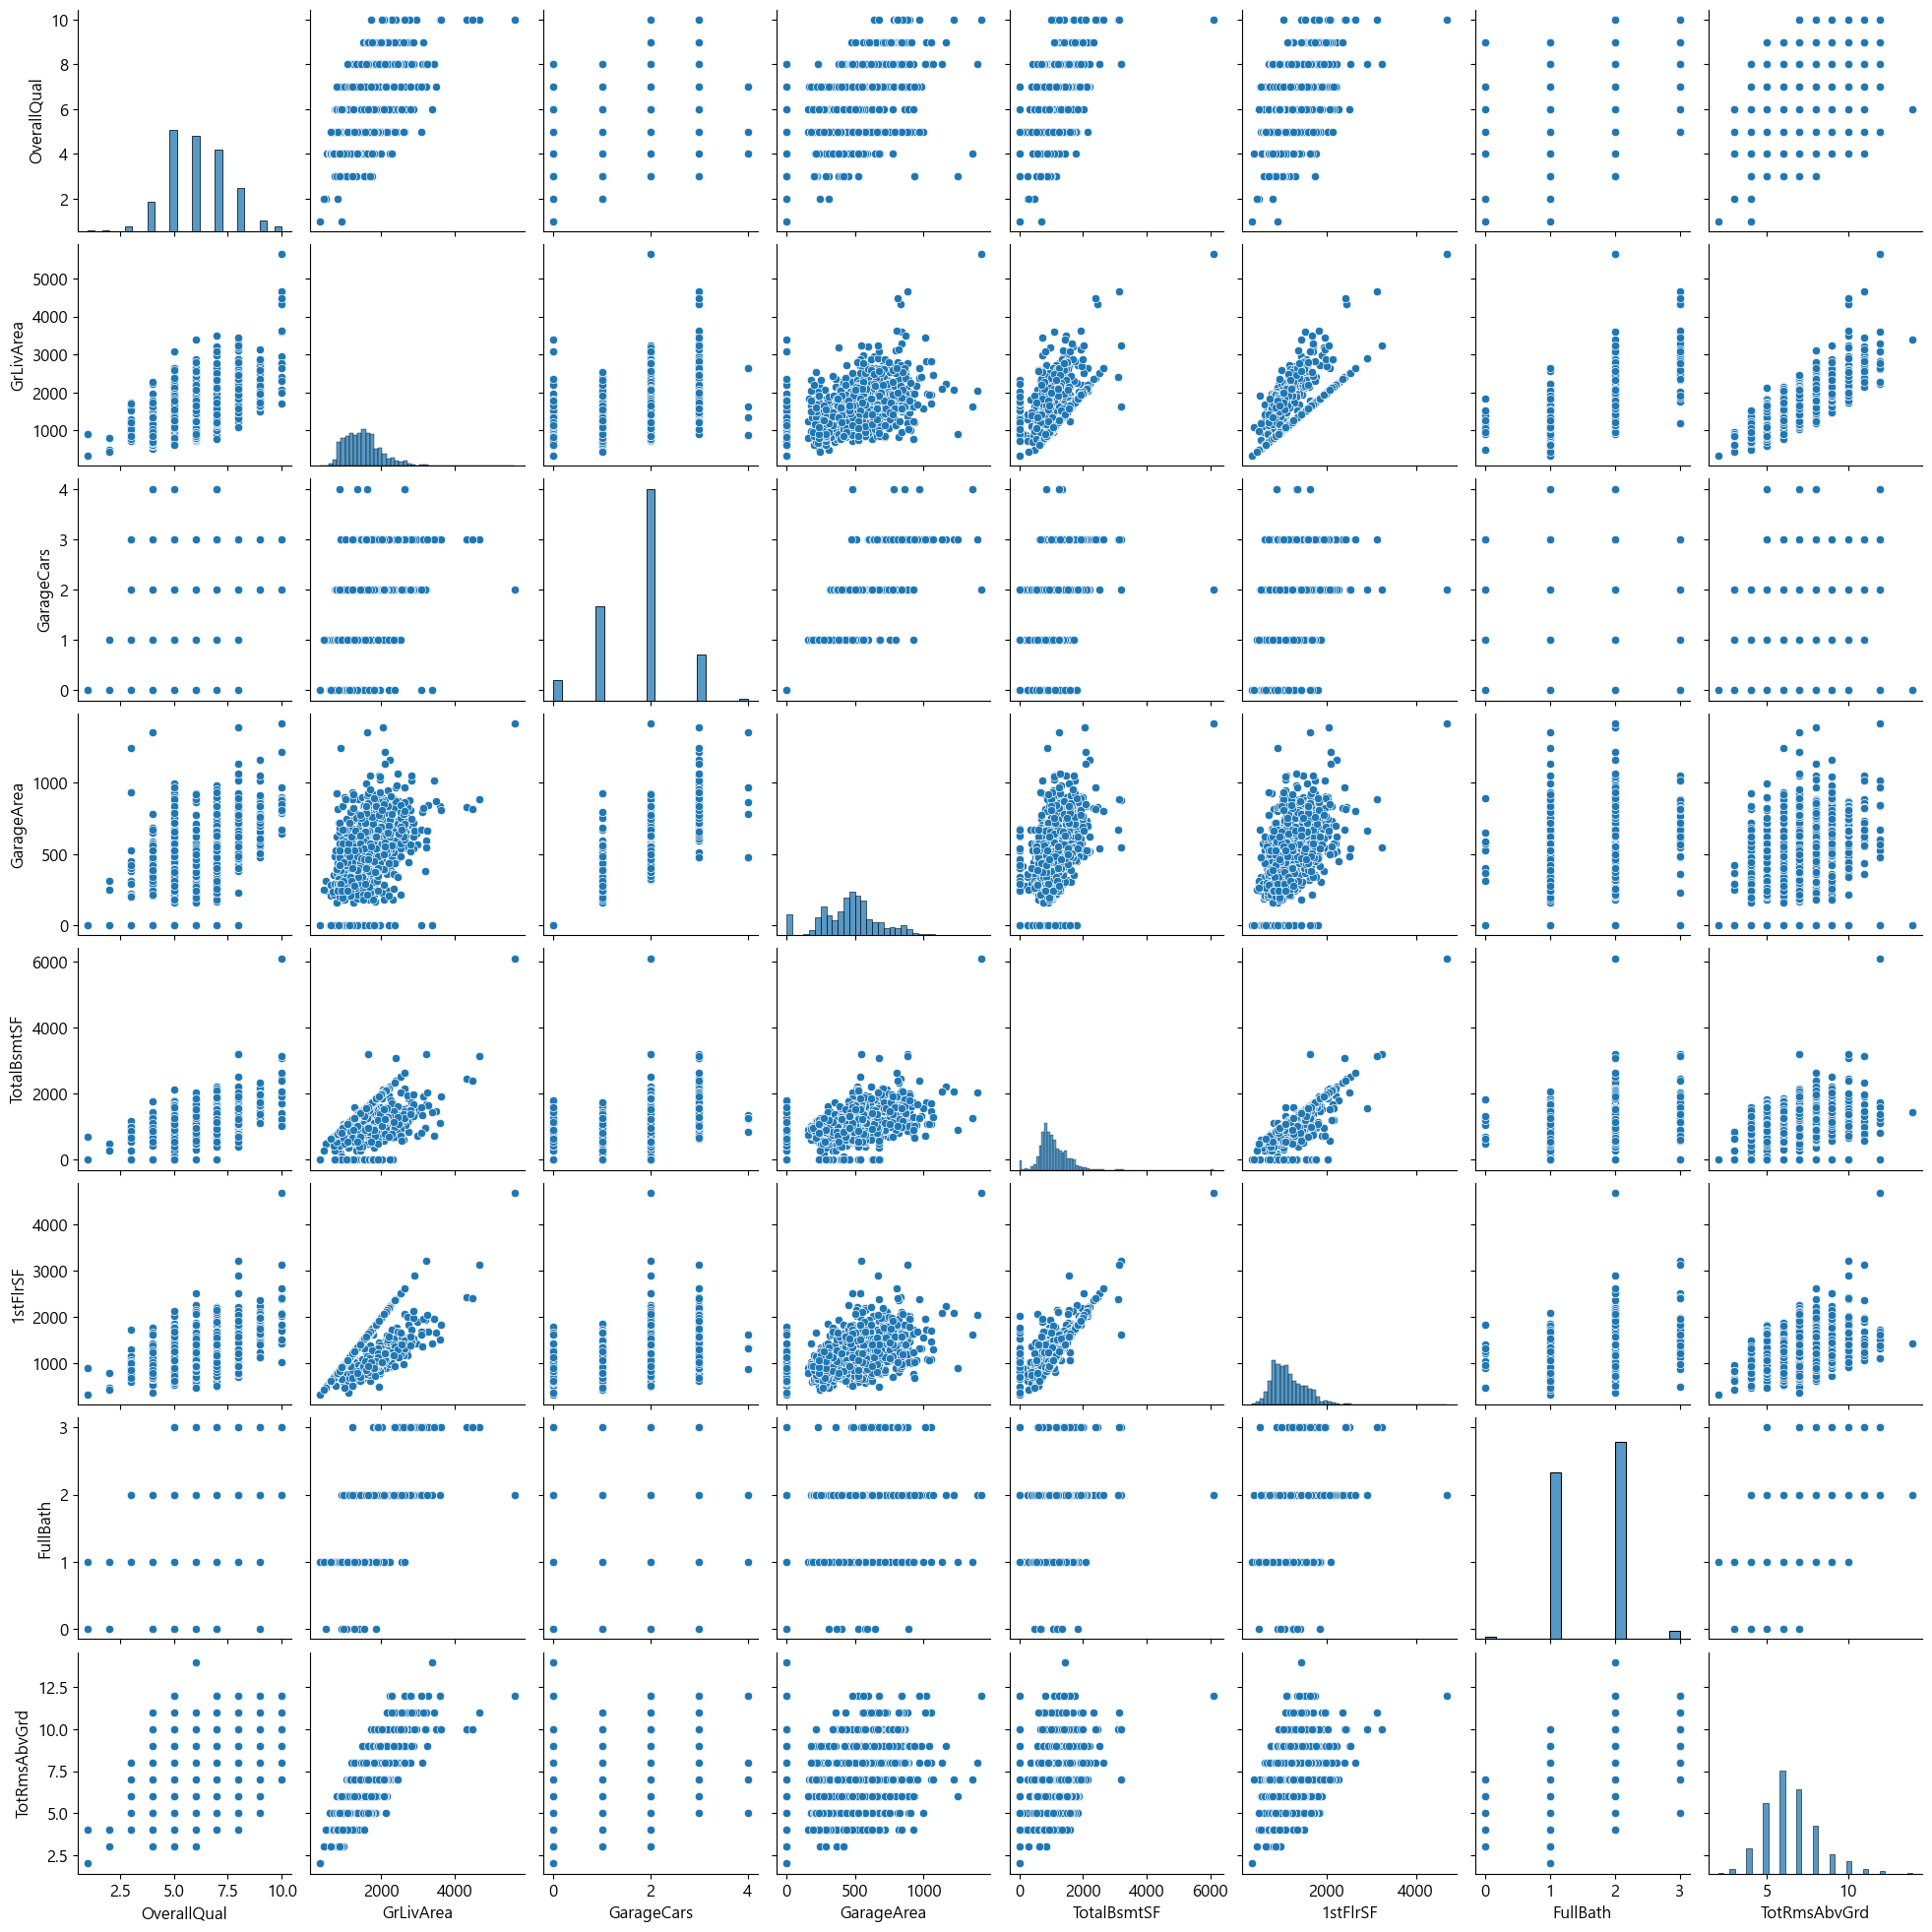

In [87]:
cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd']
sb.pairplot(df[cols])
plt.show()

In [88]:
# 상관계수가 높은 컬럼 9개를 X(독립변수)로 사용
X = df[cols] 
print(X.shape)

(1460, 8)


In [89]:
X.head(3)

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd
0,7,1710,2,548,856,856,2,8
1,6,1262,2,460,1262,1262,2,6
2,7,1786,2,608,920,920,2,6


In [90]:
Y = df['SalePrice']
print(Y.shape)
print(Y.head())

(1460,)
0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64


In [91]:
# 예측을 위한 회귀모델링은 표준화 생략 가능.
# scaler = StandardScaler()
# X = scaler.fit_transform(df)
# print(X[:3])
# X=df

- 이 위까지가 데이터 전차리. 이제부터 모델링 시작

In [92]:
# 데이터 분할
# 훈련: 90%(훈련: 80%, 검증: 20%), 검증: 10%
x_train, x_test, y_train, y_test, = train_test_split(X, Y, test_size=0.1, shuffle=True)
print(x_train.shape) # 훈련+검증 1314개, 9개 컬럼(독립변수)
print(x_test.shape) # 테스트 146개, 9개 컬럼(독립변수)
print(y_train.shape) # 훈련+검증 1314개, 1개 컬럼(종속변수) -> SalePrice
print(y_test.shape) # 테스트 146개, 1개 컬럼(종속변수) -> SalePrice

(1314, 8)
(146, 8)
(1314,)
(146,)


In [93]:
print(x_train.head(1))
print(y_train.head(1))

     OverallQual  GrLivArea  GarageCars  GarageArea  TotalBsmtSF  1stFlrSF  \
930            8       1466           3         610         1466      1466   

     FullBath  TotRmsAbvGrd  
930         2             7  
930    201000
Name: SalePrice, dtype: int64


In [124]:
# 모델 설계
# node, epoch, batch_size
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(SEED) # Global seed
np.random.seed(SEED)
random.seed(SEED)

model = Sequential()

model.add(Dense(300, input_dim=8, activation='linear', name = 'layer1'))
model.add(Dense(200, activation='linear', name = 'layer2'))
model.add(Dense(100, activation='linear', name = 'layer3'))
model.add(Dense(50, activation='linear', name = 'layer4'))
model.add(Dense(1, activation='linear', name = 'layer5'))


model.compile(optimizer=Adam(lr=0.001), loss='mse')
model.summary()

# patience=5: 손실이 5번 늘어날때까지 훈련을 계속, 5번째 종료
# restore_best_weights=True: 가중치를 가장 오차가 적었던 경우로 저장
es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

hist = model.fit(x_train, y_train, 
                    validation_split=0.2, shuffle=True, 
                    epochs=1000, batch_size=10 , callbacks=[es])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 300)               2700      
                                                                 
 layer2 (Dense)              (None, 200)               60200     
                                                                 
 layer3 (Dense)              (None, 100)               20100     
                                                                 
 layer4 (Dense)              (None, 50)                5050      
                                                                 
 layer5 (Dense)              (None, 1)                 51        
                                                                 
Total params: 88,101
Trainable params: 88,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
106/106 [============================

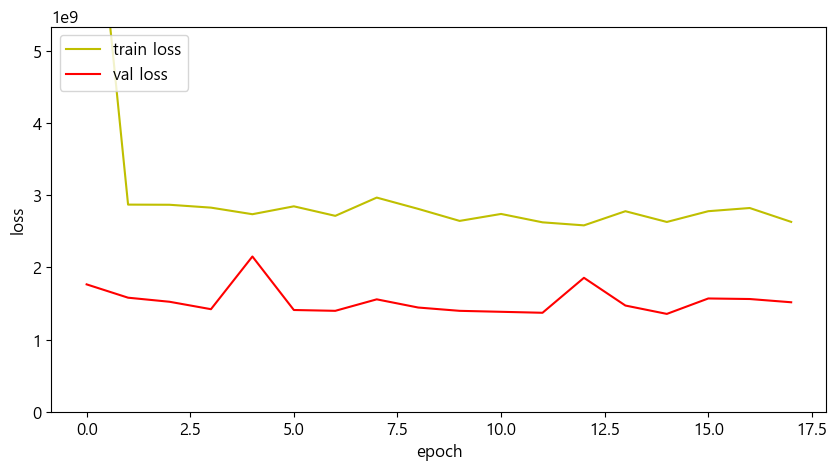

In [125]:
# 시각화
import matplotlib.pyplot as plt
%matplotlib inline  

fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 5338793728.0000]) # 값을 반영하여 변경 ★

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차

loss_ax.legend(loc='upper left') # 오차 레이블 위치

plt.show()
# train loss: 하강하면 훈련이 정상적으로 진행되고 있음
# val loss: 하강하면 훈련되지 않은 데이터를 대상으로 한 테스트도 정상적으로 진행됨.

# 과소 적합: 훈련이 부족해서 오차가 큼

In [126]:
model.save('./house_price.h5')

In [127]:
model = load_model('./house_price.h5')

In [128]:
y_test_p = model.predict(x_test) # 모델 사용
print(type(y_test_p))
print(y_test_p.shape) # (146, 1): 테스트 관측치(행)는 146개임, 예측값의 수 1

<class 'numpy.ndarray'>
(146, 1)


In [129]:
print(y_test[:3])
print(y_test_p[:3])

529    200624
491    133000
459    110000
Name: SalePrice, dtype: int64
[[245471.72]
 [133215.53]
 [118832.79]]


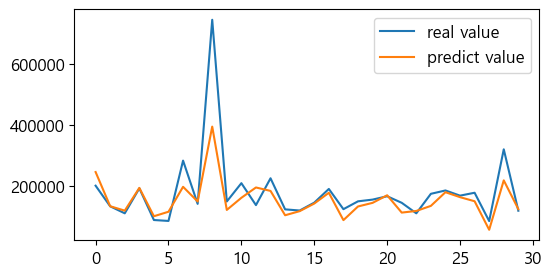

In [130]:
cnt=30
plt.plot(range(0,cnt), y_test[:cnt], label='real value') # 실제 집값
plt.plot(range(0,cnt), y_test_p[:cnt], label='predict value') # 예측 집값
plt.legend()
plt.show()